The motivation to use dithering.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tikz
def compute_corr_matrix(Z):
    """
    计算复矩阵 Z ∈ C^{N x T} 的相关系数矩阵：
        - Z 的每一行视为一个随机变量（对应一个发射天线）
        - T 是样本数

    返回 R ∈ C^{N x N}，R_ij = Corr(Z_i, Z_j)
    """
    N, T = Z.shape
    Zc = Z - Z.mean(axis=1, keepdims=True)          # 去均值
    cov = (Zc @ Zc.conj().T) / T                    # 协方差矩阵
    std = np.sqrt(np.real(np.diag(cov)))            # 每个天线的标准差
    denom = std[:, None] * std[None, :] + 1e-12     # 防止除零
    R = cov / denom
    return R

def mean_offdiag_abs(R):
    """
    计算相关系数矩阵 R 的非对角元素 |R_ij| 的平均值
    """
    N = R.shape[0]
    mask = ~np.eye(N, dtype=bool)
    return np.mean(np.abs(R[mask]))


# ===== 生成数据流 / 信道 / 预编码 =====

def generate_gaussian_streams(K_streams, num_samples):
    """
    生成 K_streams 条独立复高斯 data streams：CN(0,1)
    形状为 (K_streams, num_samples)
    """
    return (np.random.randn(K_streams, num_samples)
            + 1j * np.random.randn(K_streams, num_samples)) / np.sqrt(2.0)

def generate_channel(K_streams, N_tx):
    """
    生成 K_streams 条数据流、N_tx 根发射天线的 Rayleigh 信道矩阵:
        H ∈ C^{K_streams x N_tx}, 每个元素 ~ CN(0,1)
    """
    return (np.random.randn(K_streams, N_tx)
            + 1j * np.random.randn(K_streams, N_tx)) / np.sqrt(2.0)

def mrt_precoder(H):
    """
    MRT 预编码：
        给定 H ∈ C^{K_streams x N_tx}
        返回 W = H^H ∈ C^{N_tx x K_streams}
    """
    return H.conj().T

def estimate_bussgang_alpha(x_in, x_q):
    """
    alpha = E[ x_q * x_in^* ] / E[ |x_in|^2 ]
    """
    num = np.mean(x_q * np.conj(x_in))
    den = np.mean(np.abs(x_in) ** 2)
    return float(np.real(num / den))

def quantizer(x, eta=1.0):
    """
    1-bit DAC 量化器，对应论文中的定义：
        Q(x) = sqrt(eta/2) * (sgn(Re{x}) + j * sgn(Im{x}))

    参数
    ----
    x   : 任意形状的复数组 / ndarray
    eta : 量化缩放因子，论文中为 eta = 1/N（N 是发射天线数），
          用于保证 ||x_q||^2 = 1。这里先作为参数传入，后面
          做系统仿真时再按论文设定。

    说明
    ----
    - sgn(0) 在这里定义为 +1，这样输出总是落在 {±1 ± j} 上，
      和 1-bit DAC 的“全幅输出”模型一致。
    """
    x = np.asarray(x)

    # 实部、虚部的符号
    xr = np.sign(x.real)
    xi = np.sign(x.imag)

    # 把为 0 的地方也强制设为 +1，保证取值 ∈ {+1, -1}
    xr[xr == 0] = 1.0
    xi[xi == 0] = 1.0

    scale = np.sqrt(eta / 2.0)
    xq = scale * (xr + 1j * xi)

    return xq


def add_dither(x, sigma2):
    """
    对输入向量 x 加复高斯 dithering: d ~ CN(0, sigma2)
    """
    if sigma2 <= 0:
        return x

    # CN(0, sigma2) = N(0, sigma2/2) + j*N(0, sigma2/2)
    std = np.sqrt(sigma2 / 2)
    d = std * (np.random.randn(*x.shape) + 1j * np.random.randn(*x.shape))

    return x + d


K= 1 | mean |corr(x)| = 1.0000 | no dith: 0.4433 | with dith: 0.0635
K= 2 | mean |corr(x)| = 0.6687 | no dith: 0.1517 | with dith: 0.0301
K= 4 | mean |corr(x)| = 0.4541 | no dith: 0.0518 | with dith: 0.0132
K= 8 | mean |corr(x)| = 0.3192 | no dith: 0.0170 | with dith: 0.0053
K=16 | mean |corr(x)| = 0.2211 | no dith: 0.0066 | with dith: 0.0029
K=32 | mean |corr(x)| = 0.1564 | no dith: 0.0032 | with dith: 0.0021


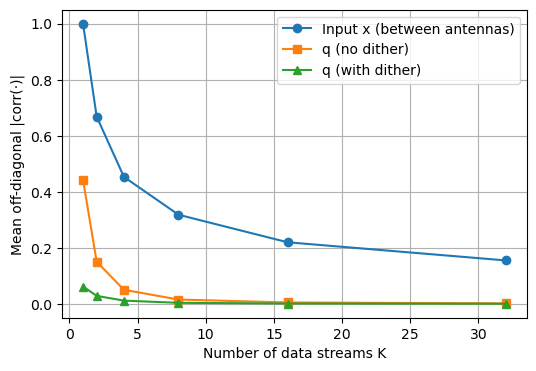

In [9]:
N_tx = 128                # 发射天线数
K_list = [1, 2, 4, 8, 16, 32]   # 不同的 data streams 数量（论文里的 K）
num_samples = 200000      # 时间样本数
sigma2_dither = 0.5       # dithering 方差，可根据需要调整

np.random.seed(2025)

mean_corr_q_no_dither = []
mean_corr_q_with_dither = []
mean_corr_x = []

for K_streams in K_list:
    eta = 1.0 / N_tx      # DAC 缩放因子，跟 N_tx 相关、与 K 无关

    # 生成信道 H、预编码 W、数据流 s
    H = generate_channel(K_streams, N_tx)       # K x N_tx
    W = mrt_precoder(H)                        # N_tx x K
    s = generate_gaussian_streams(K_streams, num_samples)  # K x T

    # 预编码后 DAC 输入信号 x (N_tx x T)
    x = W @ s
    x = x / np.sqrt(np.mean(np.abs(x) ** 2))   # 归一化总功率

    # 先看输入 x 在天线间的相关性
    R_x = compute_corr_matrix(x)
    mean_corr_x.append(mean_offdiag_abs(R_x))

    # ---- 情况 1：无 dithering ----
    x_in_no = x
    xq_no = quantizer(x_in_no, eta=eta)

    alpha_no = estimate_bussgang_alpha(x_in_no, xq_no)
    q_no = xq_no - alpha_no * x_in_no

    R_q_no = compute_corr_matrix(q_no)
    mean_corr_q_no_dither.append(mean_offdiag_abs(R_q_no))

    # ---- 情况 2：有 dithering ----
    x_in_d = add_dither(x, sigma2=sigma2_dither)
    xq_d = quantizer(x_in_d, eta=eta)

    alpha_d = estimate_bussgang_alpha(x_in_d, xq_d)
    q_d = xq_d - alpha_d * x_in_d

    R_q_d = compute_corr_matrix(q_d)
    mean_corr_q_with_dither.append(mean_offdiag_abs(R_q_d))

    print(f"K={K_streams:2d} | "
          f"mean |corr(x)| = {mean_corr_x[-1]:.4f} | "
          f"no dith: {mean_corr_q_no_dither[-1]:.4f} | "
          f"with dith: {mean_corr_q_with_dither[-1]:.4f}")

# ====== 画出相关性随 K 的变化曲线 ======

plt.figure(figsize=(6,4))
plt.plot(K_list, mean_corr_x, marker='o', label='Input x (between antennas)')
plt.plot(K_list, mean_corr_q_no_dither, marker='s', label='q (no dither)')
plt.plot(K_list, mean_corr_q_with_dither, marker='^', label='q (with dither)')
plt.xlabel("Number of data streams K")
plt.ylabel("Mean off-diagonal |corr(·)|")
plt.grid(True)
plt.legend()
tikz.save("Results/motivation_corr_diff.tex")
plt.show()

Distortion demonstration of amplitude after K-bits DACs.

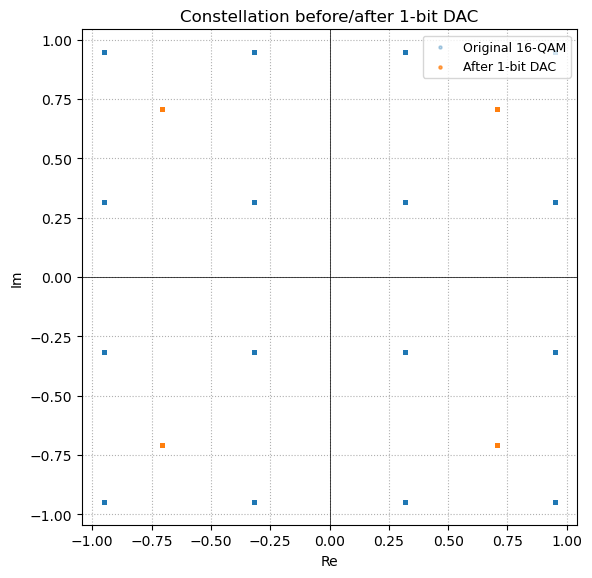

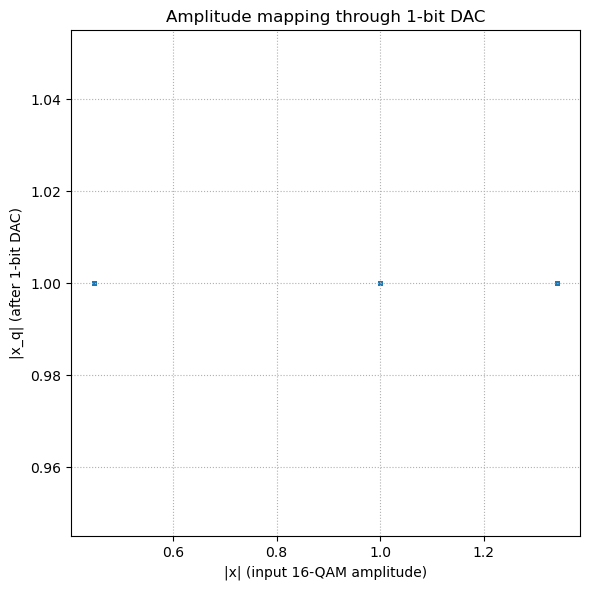

原始 16-QAM 平均功率 E[|x|^2] ≈ 0.995
量化后平均功率 E[|x_q|^2] ≈ 1.000
量化后 |x_q| 的唯一取值集合 ≈ [1.]


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ===================== 16-QAM 星座 & 符号生成 =====================

def qam16_constellation():
    """
    标准 16-QAM 星座，平均功率归一化到 1。
    点集：{±1, ±3} + j{±1, ±3} / sqrt(10)
    """
    re = np.array([-3, -1, 1, 3])
    im = np.array([-3, -1, 1, 3])
    const = (re.reshape(1, -1) + 1j * im.reshape(-1, 1)).reshape(-1)
    const = const / np.sqrt(10.0)
    return const

def generate_qam16_symbols(num_symbols, rng=None):
    """
    生成一串 16-QAM 符号（长度 num_symbols），平均功率约 1。
    """
    if rng is None:
        rng = np.random.default_rng()
    const = qam16_constellation()
    M = const.shape[0]
    idx = rng.integers(0, M, size=num_symbols)
    s = const[idx]
    return s

# ===================== 仿真：通过你给的 1-bit quantizer =====================

rng = np.random.default_rng(2025)

num_symbols = 5000          # 用来画图，几千个点就够清楚
s = generate_qam16_symbols(num_symbols, rng=rng)  # 原始 16-QAM 符号

eta = 1.0                   # 先取 eta=1，只影响整体缩放，不影响“振幅被抹平”这个现象
x_q = quantizer(s, eta=eta) # 调用你现有的 1-bit DAC 量化器

# ===================== 图 1：星座图对比 =====================

plt.figure(figsize=(6, 6))
plt.scatter(s.real, s.imag, s=5, alpha=0.3, label="Original 16-QAM")
plt.scatter(x_q.real, x_q.imag, s=5, alpha=0.7, label="After 1-bit DAC")

plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.legend(loc="upper right", fontsize=9)
plt.title("Constellation before/after 1-bit DAC")
plt.xlabel("Re")
plt.ylabel("Im")
plt.grid(True, linestyle=":")
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

# ===================== 图 2：|x| → |x_q| 振幅映射 =====================

amp_in = np.abs(s)
amp_out = np.abs(x_q)

plt.figure(figsize=(6, 6))
plt.scatter(amp_in, amp_out, s=5, alpha=0.5)
plt.xlabel("|x| (input 16-QAM amplitude)")
plt.ylabel("|x_q| (after 1-bit DAC)")
plt.title("Amplitude mapping through 1-bit DAC")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# ===================== 打印一些辅助信息 =====================

print(f"原始 16-QAM 平均功率 E[|x|^2] ≈ {np.mean(np.abs(s)**2):.3f}")
print(f"量化后平均功率 E[|x_q|^2] ≈ {np.mean(np.abs(x_q)**2):.3f}")
print(f"量化后 |x_q| 的唯一取值集合 ≈ {np.unique(np.round(amp_out, 4))}")


Simulating K = 1 ...
  Done K=1.
Simulating K = 2 ...
  Done K=2.
Simulating K = 4 ...
  Done K=4.
Simulating K = 8 ...
  Done K=8.


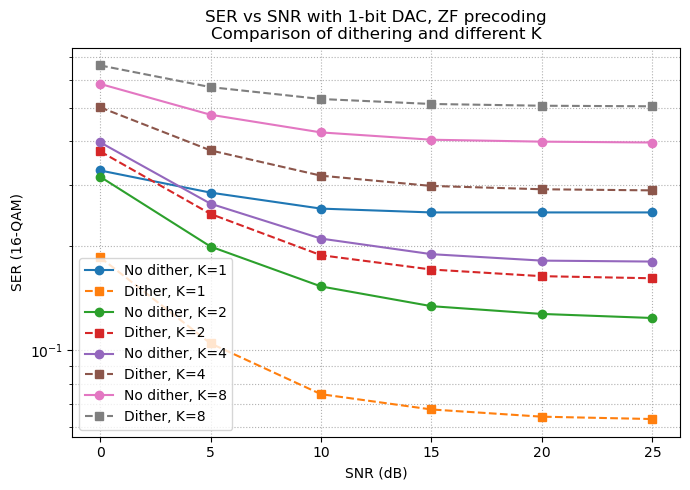

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ===================== 16-QAM 星座相关函数 =====================

def qam16_constellation():
    """
    生成标准 16-QAM 星座（Gray 码布局），
    并进行功率归一化，使平均功率 E[|s|^2] = 1。
    """
    re = np.array([-3, -1, 1, 3])
    im = np.array([-3, -1, 1, 3])
    const = (re.reshape(1, -1) + 1j * im.reshape(-1, 1)).reshape(-1)  # 16 点
    const = const / np.sqrt(10.0)  # 平均功率归一化到 1
    return const  # shape: (16,)


def generate_qam16_symbols(K_streams, num_symbols, rng=None):
    """
    生成 K_streams 条 16-QAM data streams，每条长度 num_symbols。
    返回 s: K x num_symbols, 每个元素 ∈ 16-QAM 星座，平均功率约 1。
    """
    if rng is None:
        rng = np.random.default_rng()
    const = qam16_constellation()
    M = const.shape[0]
    idx = rng.integers(0, M, size=(K_streams, num_symbols))
    s = const[idx]
    return s


def qam16_slicer(r):
    """
    对复数数组 r 做 16-QAM 硬判决：
    对每个元素选取距离最近的星座点。
    """
    const = qam16_constellation()         # (16,)
    r_flat = r.reshape(-1)               # (N,)
    # 计算到 16 个星座点的距离
    d2 = np.abs(r_flat[:, None] - const[None, :]) ** 2  # (N,16)
    idx_hat = np.argmin(d2, axis=1)      # (N,), 取值必在 [0,15]
    s_hat = const[idx_hat]               # 映射回星座点
    return s_hat.reshape(r.shape)


# ===================== MIMO / 预编码相关函数 =====================

def generate_channel(K_streams, N_tx, rng=None):
    """
    生成 K_streams x N_tx 的 Rayleigh 信道矩阵 H，元素 ~ CN(0,1)
    """
    if rng is None:
        rng = np.random.default_rng()
    H = (rng.standard_normal((K_streams, N_tx)) +
         1j * rng.standard_normal((K_streams, N_tx))) / np.sqrt(2.0)
    return H


def zf_precoder(H):
    """
    ZF 预编码：
        H: K x N_tx
        W_zf: N_tx x K，使得 H W ≈ I_K （N_tx >= K 且 H 满秩时）
    """
    K, N_tx = H.shape
    HH = H @ H.conj().T            # K x K
    W = H.conj().T @ np.linalg.inv(HH)  # N_tx x K
    return W


def compute_tx_scaling(W):
    """
    给定预编码矩阵 W (N_tx x K)，假设 s 的协方差为 I_K（每个 stream 功率 1），
    则 E[||W s||^2] = tr(W W^H)。
    我们选一个缩放因子 gamma，使平均每根天线功率为 1：
        E[||gamma W s||^2] / N_tx = 1
    => gamma = 1 / sqrt(tr(W W^H) / N_tx)
    """
    WW_h = W @ W.conj().T
    N_tx = W.shape[0]
    avg_power_per_antenna = np.trace(WW_h) / N_tx
    gamma = 1.0 / np.sqrt(np.real(avg_power_per_antenna))
    return gamma


def estimate_linear_gain(s, y):
    """
    Bussgang-like 线性增益估计：
        g_k = E[y_k s_k^*] / E[|s_k|^2]
    s: K x T
    y: K x T
    返回 g: K 维复向量
    """
    num = np.mean(y * np.conj(s), axis=1)        # K
    den = np.mean(np.abs(s) ** 2, axis=1) + 1e-12  # K
    g = num / den
    return g


# ===================== 主仿真：SER vs SNR, 有/无 dither, 不同 K =====================

# --- 仿真参数 ---
N_tx = 64                             # 发射天线数
K_list = [1, 2, 4, 8]                 # 不同的 data streams 数量（论文中的 K）
snr_dB_list = [0, 5, 10, 15, 20, 25]  # 接收端目标 SNR（dB）
num_symbols = 20000                   # 每个 (K, SNR, dithering) 下的符号数
sigma2_dither = 0.5                   # dithering 方差（可自行调整试试）
eta = 1.0 / N_tx                      # 1-bit DAC 的缩放因子

rng = np.random.default_rng(2025)

ser_no_dither = {K: [] for K in K_list}
ser_with_dither = {K: [] for K in K_list}

for K_streams in K_list:
    print(f"Simulating K = {K_streams} ...")
    # 固定一个信道，对所有 SNR 复用
    H = generate_channel(K_streams, N_tx, rng=rng)    # K x N_tx
    W = mrt_precoder(H)                               # N_tx x K
    gamma = compute_tx_scaling(W)                    # 统一功率缩放
    W_eff = gamma * W                                # 实际使用的预编码矩阵

    # 为这一组 K 生成一批 16-QAM 符号（所有 SNR / 有无 dither 共用）
    s_all = generate_qam16_symbols(K_streams, num_symbols, rng=rng)  # K x T

    # 预先计算线性（未量化）发射信号 x_lin (N_tx x T)
    x_lin = W_eff @ s_all

    # --- 两种情况：无 dithering / 有 dithering ---
    x_in_dict = {
        "no": x_lin,
        "dither": add_dither(x_lin, sigma2=sigma2_dither)
    }

    for mode in ["no", "dither"]:
        x_in = x_in_dict[mode]

        # 量化：1-bit DAC
        x_q = quantizer(x_in, eta=eta)  # N_tx x T，不依赖 SNR

        for snr_dB in snr_dB_list:
            snr_linear = 10.0 ** (snr_dB / 10.0)

            # 接收信号： y = sqrt(snr) * H x_q + n, n ~ CN(0,1)
            noise = (rng.standard_normal((K_streams, num_symbols)) +
                     1j * rng.standard_normal((K_streams, num_symbols))) / np.sqrt(2.0)

            y = np.sqrt(snr_linear) * (H @ x_q) + noise  # K x T

            # 估计每个 stream 的等效线性增益 g_k
            g = estimate_linear_gain(s_all, y)          # K
            # 构造简单的一阶均衡器： r_k = (g_k^* / |g_k|^2) * y_k
            g_eq = np.conj(g) / (np.abs(g) ** 2 + 1e-12)  # K
            r = g_eq[:, None] * y                       # K x T

            # 16-QAM 判决
            s_hat = qam16_slicer(r)

            # 计算 SER
            symbol_errors = np.sum(s_hat != s_all)
            ser = symbol_errors / (K_streams * num_symbols)

            if mode == "no":
                ser_no_dither[K_streams].append(ser)
            else:
                ser_with_dither[K_streams].append(ser)

    print(f"  Done K={K_streams}.")


# ===================== 画图：SER vs SNR =====================

plt.figure(figsize=(7, 5))

for K_streams in K_list:
    plt.semilogy(snr_dB_list, ser_no_dither[K_streams],
                 marker='o', linestyle='-', label=f"No dither, K={K_streams}")
    plt.semilogy(snr_dB_list, ser_with_dither[K_streams],
                 marker='s', linestyle='--', label=f"Dither, K={K_streams}")

plt.xlabel("SNR (dB)")
plt.ylabel("SER (16-QAM)")
plt.title("SER vs SNR with 1-bit DAC, ZF precoding\nComparison of dithering and different K")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()
